In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

import nltk
from nltk.corpus import stopwords # tried to use this vocab but ended up with lower accuracy than the built in stopwords
nltk.download('stopwords')


x_train_df = pd.read_csv('../data_reviews/x_train.csv')
x_test_df = pd.read_csv('../data_reviews/x_test.csv')
y_train_df = pd.read_csv('../data_reviews/y_train.csv')

save_dir = os.path.abspath('../data_reviews/')
tr_embeddings_ND = np.load(os.path.join(save_dir, 'x_train_BERT_embeddings.npy'))
te_embeddings_ND = np.load(os.path.join(save_dir, 'x_test_BERT_embeddings.npy'))

# from sklearn.preprocessing import normalize
# tr_embeddings_ND = normalize(tr_embeddings_ND)
# te_embeddings_ND = normalize(te_embeddings_ND)


tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

SEED = 12345

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from matplotlib import pyplot as plt

import seaborn as sns
#This sets the default style for all figures. 
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [3]:
# define logistic regression pipeline function
def make_mlp_pipeline():
    pipeline = Pipeline(
        steps=[
         ('mlp', MLPClassifier(random_state=SEED, max_iter=5000))
        ])
    return pipeline

In [4]:
pipe = make_mlp_pipeline()

In [5]:
# Splitting up training data into training set and validation set
x_train, x_va, y_train, y_va = train_test_split(tr_embeddings_ND, y_train_df.values.ravel(), test_size=0.2, random_state=SEED)
# y_train = y_train.values.ravel()
# y_va = y_va.values.ravel()

In [6]:
# make hyperparameter alpha grid (regularization strength), 20 logspaced values from 10e-6 to 10e6
alpha_grid = np.logspace(-2, 2, 10)
param_grid = {'mlp__alpha': alpha_grid}

# perform grid search and fit the model
grid_search = GridSearchCV(
    pipe, # estimator
    param_grid=param_grid, # hyperparameter C
    cv=5, # 5-fold cross validation
    scoring='roc_auc', # calculates AUROC to compare the hyperparameter(s)
    return_train_score = True
)

grid_search.fit(x_train, y_train)
grid_predictions_va = grid_search.predict_proba(x_va)
grid_predictions_tr = grid_search.predict_proba(x_train)

# calculate and print accuracy for training and validation datasets
print("Training Accuracy:", roc_auc_score(y_train, grid_predictions_tr[:,1]))
print("Validation Accuracy:", roc_auc_score(y_va, grid_predictions_va[:,1]))

# best parameter found in the grid search
print("Best Alpha:", grid_search.best_params_)

Training Accuracy: 0.9832626403686668
Validation Accuracy: 0.9675991040266708
Best Alpha: {'mlp__alpha': 4.6415888336127775}


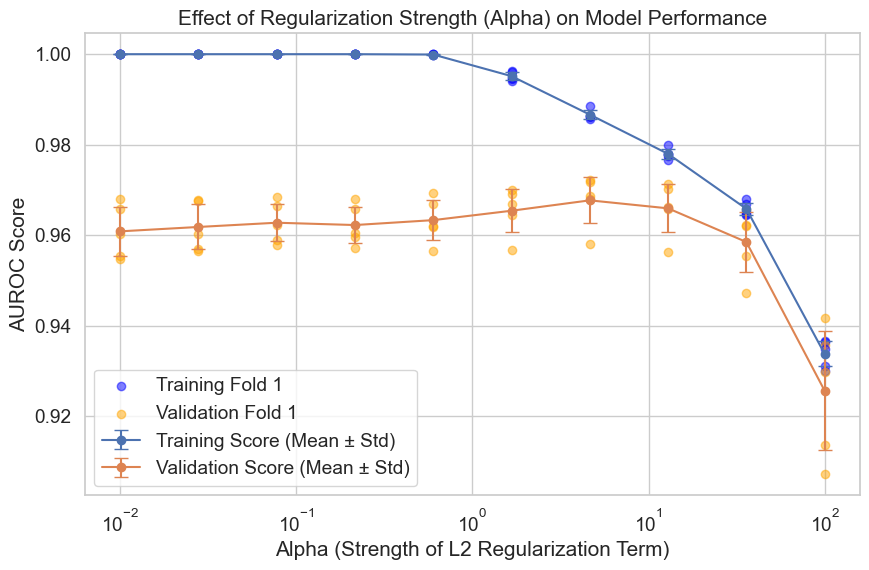

In [7]:
# Extract the results from grid search
mean_train_score = grid_search.cv_results_['mean_train_score']
mean_test_score = grid_search.cv_results_['mean_test_score']

# Extract the standard deviation for training and validation folds
std_train_score = grid_search.cv_results_['std_train_score']
std_test_score = grid_search.cv_results_['std_test_score']

# Extract the scores of each fold for both training and validation sets
train_scores = grid_search.cv_results_['split0_train_score'], grid_search.cv_results_['split1_train_score'], \
               grid_search.cv_results_['split2_train_score'], grid_search.cv_results_['split3_train_score'], \
               grid_search.cv_results_['split4_train_score']

test_scores = grid_search.cv_results_['split0_test_score'], grid_search.cv_results_['split1_test_score'], \
              grid_search.cv_results_['split2_test_score'], grid_search.cv_results_['split3_test_score'], \
              grid_search.cv_results_['split4_test_score']

# Plot the performance of different regularization strengths
fig, ax = plt.subplots(figsize=(10, 6))

# Plot mean train and validation scores with standard deviation as error bars
ax.errorbar(alpha_grid, mean_train_score, yerr=std_train_score, label='Training Score (Mean ± Std)', fmt='-o', capsize=5)
ax.errorbar(alpha_grid, mean_test_score, yerr=std_test_score, label='Validation Score (Mean ± Std)', fmt='-o', capsize=5)

# Add individual fold performance as points
for i in range(5):
    ax.scatter(alpha_grid, train_scores[i], alpha=0.5, color='blue', label=f'Training Fold {i+1}' if i == 0 else "")
    ax.scatter(alpha_grid, test_scores[i], alpha=0.5, color='orange', label=f'Validation Fold {i+1}' if i == 0 else "")

# Set log scale for x-axis
ax.set_xscale('log')

# Set labels and title
ax.set_xlabel('Alpha (Strength of L2 Regularization Term)')
ax.set_ylabel('AUROC Score')
ax.set_title('Effect of Regularization Strength (Alpha) on Model Performance')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [8]:
grid_predictions_test = grid_search.predict_proba(te_embeddings_ND)
grid_predictions_test_T = np.transpose(grid_predictions_test)
print(str(grid_predictions_test_T))

file = open("yproba1_test.txt", "w+")
for value in grid_predictions_test[:,1]:
    line = str(value) + "\n"
    file.write(line)
file.close()



[[0.95918363 0.9143703  0.9352145  ... 0.02631205 0.0082587  0.0076437 ]
 [0.04081638 0.08562969 0.06478548 ... 0.97368795 0.9917413  0.9923563 ]]
